<a href="https://colab.research.google.com/github/Avichay3/final_project_eyal/blob/main/final_project_classifier_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

!pip install transformers datasets evaluate -q
!pip install torch torchvision torchaudio -q
!pip install scikit-learn pandas numpy -q


import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "true"

import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
import evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.3 MB/s eta 0:00:00


In [3]:

from google.colab import files
uploaded = files.upload()

file_name = list(uploaded.keys())[0]

Saving heldout_pair_data.jsonlist to heldout_pair_data.jsonlist


In [4]:

import json
data = [json.loads(line) for line in open(file_name, 'r')]
df = pd.DataFrame(data)
print("Columns:", df.columns.tolist())


pos_df = pd.DataFrame({
    "text": df["positive"],
    "label": 1
})
neg_df = pd.DataFrame({
    "text": df["negative"],
    "label": 0
})

combined_df = pd.concat([pos_df, neg_df], ignore_index=True)
combined_df = combined_df.dropna(subset=["text"]).reset_index(drop=True)


combined_df["text"] = combined_df["text"].apply(
    lambda x: " ".join(x) if isinstance(x, list) else str(x)
)

print("Total samples:", len(combined_df))
combined_df.head()

Columns: ['op_author', 'op_text', 'op_title', 'positive', 'negative', 'op_name']
Total samples: 1614


,text,label
0,"{'ancestor': 't1_cundk5r', 'author': 'ghoooooo...",1
1,"{'ancestor': 't1_cunbkbz', 'author': 'archagon...",1
2,"{'ancestor': 't1_cun0c3t', 'author': 'huadpe',...",1
3,"{'ancestor': 't1_cumn3j4', 'author': 'ReOsIr10...",1
4,"{'ancestor': 't1_cumhf65', 'author': 'BadKeyMa...",1


In [5]:
pairs = []

for sample in data:
    op_text = sample.get("op_text", "")

    # positive comment(s)
    if isinstance(sample.get("positive"), dict):
        comments = sample["positive"].get("comments", [])
        for c in comments:
            comment_text = c.get("body", "")
            if comment_text:
                pairs.append({
                    "op_text": op_text,
                    "cm_text": comment_text,
                    "label": 1
                })

    # negative comment(s)
    if isinstance(sample.get("negative"), dict):
        comments = sample["negative"].get("comments", [])
        for c in comments:
            comment_text = c.get("body", "")
            if comment_text:
                pairs.append({
                    "op_text": op_text,
                    "cm_text": comment_text,
                    "label": 0
                })

combined_df = pd.DataFrame(pairs)
combined_df = combined_df.dropna(subset=["op_text", "cm_text"]).reset_index(drop=True)
print("Total pairs:", len(combined_df))
print(combined_df.sample(3))


Total pairs: 2142
                                                op_text  \
640   So I was arguing with a friend of mine about t...   
912   I have had friendships with various males, and...   
1124  Throwaway account, my main is used for school....   

                                                cm_text  label  
640   You're right in a few ways, but ultimately - w...      1  
912   If I understand you correctly, your view is th...      0  
1124  I don't know about your jurisdiction, but if t...      0  


In [6]:
from transformers import AutoTokenizer

#
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

# pick one sample from the data
sample = combined_df.sample(1).iloc[0]

op_text = sample["op_text"]
cm_text = sample["cm_text"]
label = sample["label"]

print("\n ORIGINAL POST:")
print(op_text[:500], "..." if len(op_text) > 500 else "")
print("\n COMMENT:")
print(cm_text[:300], "..." if len(cm_text) > 300 else "")
print("\n LABEL:", label)

# tokenization
encoded = tokenizer(
    op_text,
    cm_text,
    truncation=True,
    max_length=256,
    return_tensors="pt",
    return_token_type_ids=True
)

print("\n Keys returned by tokenizer:", list(encoded.keys()))

# see the tokens itself
tokens = tokenizer.convert_ids_to_tokens(encoded["input_ids"][0])
print("\n TOKENS sequence:")
print(tokens)

# the sequence length
print("\n Sequence length:", len(tokens), "tokens")

# see the masks
print("\n input_ids:", encoded["input_ids"][0][:40], "...")
print("\n attention_mask:", encoded["attention_mask"][0][:40], "...")
if "token_type_ids" in encoded:
    print("\n token_type_ids:", encoded["token_type_ids"][0][:40], "...")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(



 ORIGINAL POST:
To my knowledge there are no peer reviewed sources that link GMOs to any negative health effects. There is as much reason to believe genes manipulated in a lab are inherently harmful as there is for genes selected through domestication. I am asking for a CMV because I have not done thorough research other than reading a few articles supporting my view including a recent cover story for Nat. Geo, a magazine I highly respect. However as a scientifically-minded person, I can't ignore the massive mo ...

 COMMENT:
I don't believe it is irrational at all. Bugs are found in the lifecycle of a software, and products that have been around have had a longer lifecyle and typically have had an opportunity to have bugs be discovered. 

If you are performing an upgrade, yes. You are getting new functionality. 

Howeve ...

 LABEL: 0

 Keys returned by tokenizer: ['input_ids', 'token_type_ids', 'attention_mask']

 TOKENS sequence:
['[CLS]', '▁To', '▁my', '▁knowledge', '▁there', '▁ar

100%|██████████| 1000/1000 [00:02<00:00, 445.72it/s]



 Token length statistics:
mean: 900.886
median: 817.0
90th percentile: 1480.1
95th percentile: 1743.1
max: 3077


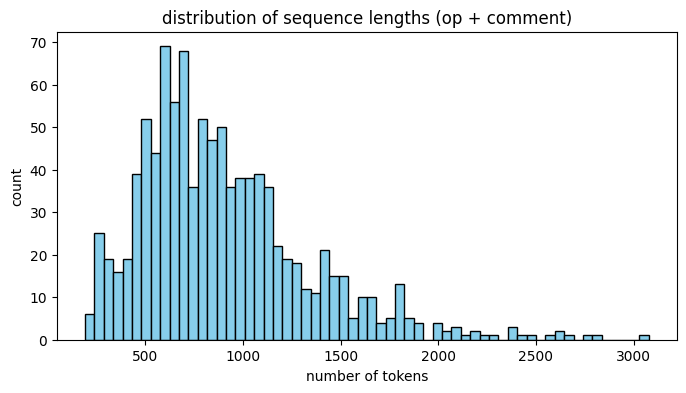

In [7]:
# check the length sequence
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def measure_token_lengths(df, tokenizer):
    lengths = []
    for op, cm in tqdm(zip(df["op_text"], df["cm_text"]), total=len(df)):
        enc = tokenizer(op, cm, truncation=False, add_special_tokens=True)
        lengths.append(len(enc["input_ids"]))
    return np.array(lengths)

lens = measure_token_lengths(combined_df.sample(1000, random_state=42), tokenizer)

print("\n Token length statistics:")
print("mean:", np.mean(lens))
print("median:", np.median(lens))
print("90th percentile:", np.percentile(lens, 90))
print("95th percentile:", np.percentile(lens, 95))
print("max:", np.max(lens))

plt.figure(figsize=(8,4))
plt.hist(lens, bins=60, color="skyblue", edgecolor="black")
plt.title("distribution of sequence lengths (op + comment)")
plt.xlabel("number of tokens")
plt.ylabel("count")
plt.show()


The average of number of tokens is 900, which is a much greater than 256.
It means that big part of the post and comment is deleted.
If we choose 512 (which is the number of tokens that DeBERTa or RoBERTa can handle), only 70% will receive full representation (cause the median is 817).

In [8]:
from transformers import AutoTokenizer
tok = AutoTokenizer.from_pretrained("bert-base-uncased")

op = "I think veganism doesn't make any difference."
comment = "Actually, it helps reduce animal suffering."

enc = tok(op, comment)
print(enc["input_ids"])
print(tok.convert_ids_to_tokens(enc["input_ids"]))


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

[101, 1045, 2228, 15942, 28113, 2987, 1005, 1056, 2191, 2151, 4489, 1012, 102, 2941, 1010, 2009, 7126, 5547, 4111, 6114, 1012, 102]
['[CLS]', 'i', 'think', 'vega', '##nism', 'doesn', "'", 't', 'make', 'any', 'difference', '.', '[SEP]', 'actually', ',', 'it', 'helps', 'reduce', 'animal', 'suffering', '.', '[SEP]']


In [9]:
train_df, test_df = train_test_split(
    combined_df,
    test_size=0.2,
    random_state=42,
    stratify=combined_df["label"]
)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Some EDA

total samples: 2142
train samples: 1713
test samples: 429

Label distribution (0 = Not Persuasive, 1 = Persuasive):
label
1    1134
0    1008
Name: count, dtype: int64


/tmp/ipython-input-86125451.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=combined_df, x='label', palette='pastel')


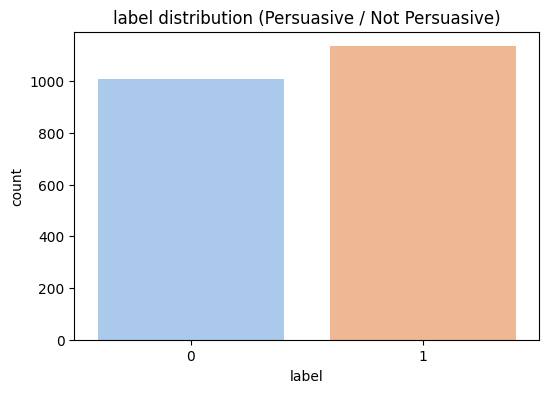

KeyError: 'text'

In [10]:

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd

print("total samples:", len(combined_df))
print("train samples:", len(train_df))
print("test samples:", len(test_df))
print("\nLabel distribution (0 = Not Persuasive, 1 = Persuasive):")
print(combined_df['label'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(data=combined_df, x='label', palette='pastel')
plt.title("label distribution (Persuasive / Not Persuasive)")
plt.xlabel("label")
plt.ylabel("count")
plt.show()

# 2. Text length (in words)
combined_df['text_length'] = combined_df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(7,4))
sns.histplot(data=combined_df, x='text_length', hue='label', bins=40, kde=True, palette='Set2')
plt.title("text Length Distribution by class")
plt.xlabel("text length (words)")
plt.ylabel("number of samples")
plt.show()

def get_top_words(texts, n=10):
    all_words = " ".join(texts).split()
    common = Counter(all_words).most_common(n)
    return pd.DataFrame(common, columns=["word", "count"])

top_pos = get_top_words(combined_df[combined_df["label"]==1]["text"])
top_neg = get_top_words(combined_df[combined_df["label"]==0]["text"])

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.barplot(data=top_pos, x='count', y='word', palette='Greens_r')
plt.title("Most Frequent Words in Persuasive Texts")

plt.subplot(1,2,2)
sns.barplot(data=top_neg, x='count', y='word', palette='Reds_r')
plt.title("Most Frequent Words in Non-Persuasive Texts")
plt.tight_layout()
plt.show()

In [ ]:
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=False, max_length=512)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)


model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


for name, param in model.deberta.embeddings.named_parameters():
    param.requires_grad = False
for name, param in model.deberta.encoder.layer[:6].named_parameters():
    param.requires_grad = False


batch_size = 8
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = metric.compute(predictions=predictions, references=labels)
    return acc

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    report_to="none",
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir="./logs",
    logging_steps=50,
)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/1713 [00:00<?, ? examples/s]

KeyError: 'text'

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)


trainer.train()

/tmp/ipython-input-3150737086.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.688300,0.623425,0.678019
2,0.579600,0.572722,0.684211
3,0.499900,0.552069,0.702786
4,0.535200,0.589220,0.674923
5,0.472500,0.594616,0.684211
6,0.457700,0.659474,0.684211


TrainOutput(global_step=972, training_loss=0.5376774734920926, metrics={'train_runtime': 1029.8373, 'train_samples_per_second': 12.536, 'train_steps_per_second': 1.573, 'total_flos': 2038094785032192.0, 'train_loss': 0.5376774734920926, 'epoch': 6.0})

In [ ]:
results = trainer.evaluate()
print(" Final Evaluation Results:", results)


trainer.save_model("./deberta_persuasion_model")
print("Model saved to ./deberta_persuasion_model")

 Final Evaluation Results: {'eval_loss': 0.6117265820503235, 'eval_accuracy': 0.6965944272445821, 'eval_runtime': 6.8737, 'eval_samples_per_second': 46.991, 'eval_steps_per_second': 5.965, 'epoch': 6.0}
Model saved to ./deberta_persuasion_model


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving final_project_classifier.ipynb to final_project_classifier (1).ipynb


In [ ]:
import nbformat

path = "final_project_classifier.ipynb"

nb = nbformat.read(path, as_version=4)


if "widgets" in nb.get("metadata", {}):
    del nb["metadata"]["widgets"]

for cell in nb.cells:
    if "widgets" in cell.get("metadata", {}):
        del cell["metadata"]["widgets"]

nbformat.write(nb, path)
print("Notebook cleaned successfully!")


Notebook cleaned successfully!


In [ ]:
from google.colab import files
files.download("final_project_classifier.ipynb")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>